## **Installing packages**

In [1]:
!pip install atspy

     |████████████████████████████████| 2.1MB 9.7MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 327kB 46.1MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
     |████████████████████████████████| 337kB 42.2MB/s 
     |████████████████████████████████| 13.1MB 229kB/s 
     |████████████████████████████████| 488.3MB 34kB/s 
     |████████████████████████████████| 3.7MB 43.1MB/s 
     |████████████████████████████████| 10.4MB 40.0MB/s 
     |████████████████████████████████| 40kB 6.5MB/s 
     |████████████████████████████████| 1.5MB 40.5MB/s 
     |████████████████████████████████| 7.1MB 24.5MB/s 
     |████████████████████████████████| 225kB 59.5MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 412.3MB 44kB/s 
     |████████████████████████████████| 102kB 64kB/s 
     |████████████████████████████████| 753.4MB 18kB/s 
   

In [2]:
!pip install pigar

     |████████████████████████████████| 6.9MB 6.3MB/s 


In [2]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 21.2MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=1d472ee1503d4050ad7a751053411780b34d113fb9eaf281f99ceb477afef76a
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [5]:
!pip install fbprophet

In [7]:
# Update: /usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py
#from holidays import WEEKEND, HolidayBase, easter, rd
#to

# from holidays import WEEKEND, HolidayBase
# from dateutil.easter import easter
# from dateutil.relativedelta import relativedelta as rd

## **1. Data Preparation**

In [91]:
# Import necessary libraries and packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import warnings
warnings.filterwarnings('ignore')

# Import yahoo's finance API library for historical stock data
import yfinance as yf
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from atspy import AutomatedModel

In [2]:
# Top 5 NSE Companies by 'Market Cap' as on 24-12-20
top5_tickers = ['RELIANCE.NS','TCS.NS','HDFCBANK.NS','HINDUNILVR.NS','INFY.NS']

In [8]:
def prepare_data(ticker):
    
    # Start date is chosen as per available news data
    start_date = datetime.date(2017,11,17)  
    end_date = datetime.date(2021,1,2)
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')

    # Calculate %change for a day using present and previous day 'Close' prices 
    per_change = 100*(df['Close'].values[1:]-df['Close'].values[:-1])/df['Close'].values[:-1]
    per_change = np.round(per_change, 3)

    # Since, 17-11-2017 has no 'per_change' value, we skip this starting date
    df1 = df[1:].copy()
    df1['%Change'] = per_change
    df1['Trend'] = df1['%Change'].map(lambda x:0 if x<=0 else 1)

    return df1

In [9]:
# Preparing data for top 5 NSE companies
ril_df = prepare_data('RELIANCE.NS')
tcs_df = prepare_data('TCS.NS')
hdfc_df = prepare_data('HDFCBANK.NS')
hul_df = prepare_data('HINDUNILVR.NS')
infy_df = prepare_data('INFY.NS')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
hul_df.shape

(768, 8)

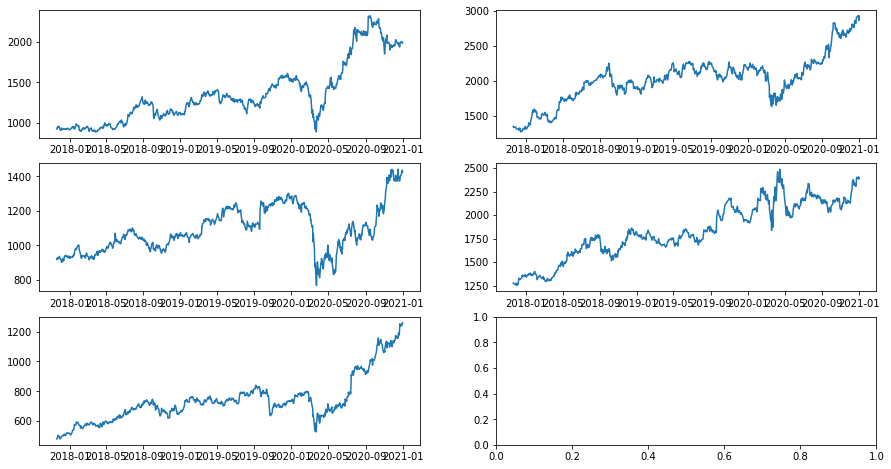

In [7]:
fig, axs = plt.subplots(3,2, figsize=(15,8))
axs[0,0].plot(ril_df['Close'])
axs[0,1].plot(tcs_df['Close'])
axs[1,0].plot(hdfc_df['Close'])
axs[1,1].plot(hul_df['Close'])
axs[2,0].plot(infy_df['Close'])
plt.show()

## **2. Atspy Models for Close Prices**

In [6]:
df = hul_df.copy()
df = df[['Close']] 
df.shape

(768, 1)

In [7]:
# Creating date indexes to work Atspy models (to avoid validation errors)
dates = pd.date_range(start=df.index[0].date(), freq="B", periods=len(df))
dates

DatetimeIndex(['2017-11-20', '2017-11-21', '2017-11-22', '2017-11-23',
               '2017-11-24', '2017-11-27', '2017-11-28', '2017-11-29',
               '2017-11-30', '2017-12-01',
               ...
               '2020-10-15', '2020-10-16', '2020-10-19', '2020-10-20',
               '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-26',
               '2020-10-27', '2020-10-28'],
              dtype='datetime64[ns]', length=768, freq='B')

In [8]:
df.index = dates
train_df = df.iloc[0:int(0.90*len(df))]
test_df = df.iloc[int(0.90*len(df)):]

In [9]:
print("No. of samples in train data: {}".format(train_df.shape))
print("No. of samples in test data: {}".format(test_df.shape))

No. of samples in train data: (691, 1)
No. of samples in test data: (77, 1)


In [10]:
print(train_df.index.freq)

<BusinessDay>


In [11]:
model_list=["HWAAS","HWAMS","Gluonts","Prophet","NBEATS", "TBAT", "TATS", "TBATS1", "TBATP1", "TBATS2"]

am = AutomatedModel(df=train_df, model_list=model_list, 
                    season="infer_from_data", forecast_len=77)
forecast_in, performance = am.forecast_insample()
forecast_out = am.forecast_outsample()

<class 'pandas.core.frame.DataFrame'>
The data has been successfully parsed by infering a frequency, and establishing a 'Date' index and 'Target' column.
518
An insample split of training size 518 and testing size 173 has been constructed
Model HWAAS is being trained for in sample prediction
Model HWAMS is being trained for in sample prediction


INFO:root:Start model training


Model Gluonts is being trained for in sample prediction


INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:19<00:00,  2.62it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[0] Elapsed time 19.100 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=6.813450
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:16<00:00,  3.05it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[1] Elapsed time 16.409 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=5.426273
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:16<00:00,  3.05it/s, avg_epoch_loss=5.15]
INFO:root:Epoch[2] Elapsed time 16.381 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=5.147950
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:16<00:00,  3.04it/s, avg_epoch_loss=5.09]
INFO:root:Epoch[3] Elapsed time 16.477 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=5.085178
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:16<00:00,  3.07it/s, avg_epoch_loss=5.03]
INFO:root:Epoch[4] El

Model Prophet is being trained for in sample prediction
Model NBEATS is being trained for in sample prediction
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=173, forecast_length=173, share_thetas=False) at @139953577448392
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=173, forecast_length=173, share_thetas=False) at @139953576993512
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=173, forecast_length=173, share_thetas=False) at @139953576993960
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=173, forecast_length=173, share_thetas=False) at @139953576993400
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=173, forecast_length=173, share_thetas=False) at @139953576994240
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=173, forecast_length=173, share_thetas=False) at @139

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

Model Gluonts is being trained for out of sample prediction


INFO:root:Number of parameters in DeepARTrainingNetwork: 22204
100%|██████████| 50/50 [00:08<00:00,  6.08it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[0] Elapsed time 8.230 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=6.855967
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:07<00:00,  6.45it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[1] Elapsed time 7.756 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=5.632183
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:07<00:00,  6.53it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[2] Elapsed time 7.659 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=5.419456
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:07<00:00,  6.53it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[3] Elapsed time 7.656 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=5.381128
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:07<00:00,  6.44it/s, avg_epoch_loss=5.29]
INFO

Model Prophet is being trained for out of sample prediction
Model NBEATS is being trained for out of sample prediction
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=77, forecast_length=77, share_thetas=False) at @139953491245096
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=77, forecast_length=77, share_thetas=False) at @139953596877680
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=77, forecast_length=77, share_thetas=False) at @139953575900104
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=77, forecast_length=77, share_thetas=False) at @139953575900160
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=77, forecast_length=77, share_thetas=False) at @139953596566160
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=77, forecast_length=77, share_thetas=False) at @1399535

In [12]:
forecast_in.head()

,Target,HWAAS,HWAMS,Gluonts,Prophet,NBEATS,TBAT,TATS,TBATS1,TBATP1,TBATS2
Date,,,,,,,,,,,
2019-11-14,1938.050049,1905.670034,1893.612187,2138.345703,2105.739207,1516.962891,1937.449126,1937.449126,1937.449126,1937.449126,1937.449126
2019-11-15,1927.449951,1843.040881,1829.383643,2139.189209,2105.708784,1684.768677,1938.239312,1938.239312,1938.239312,1938.239312,1938.239312
2019-11-18,1915.449951,1766.797700,1737.481195,2139.653809,2109.008924,1627.636597,1939.029821,1939.029821,1939.029821,1939.029821,1939.029821
2019-11-19,1920.699951,1707.949837,1667.400970,2128.670898,2111.733684,1645.290527,1939.820652,1939.820652,1939.820652,1939.820652,1939.820652
2019-11-20,1929.349976,1669.835827,1623.123195,2124.892090,2117.559951,1678.917358,1940.611805,1940.611805,1940.611805,1940.611805,1940.611805


In [13]:
forecast_in.to_pickle('/content/drive/MyDrive/INeuron-StockPredict/nifty_top5_data/hul_train.pkl')

In [14]:
forecast_out.to_pickle('/content/drive/MyDrive/INeuron-StockPredict/nifty_top5_data/hul_test.pkl')

In [15]:
forecast_out.head(3)

,HWAAS,HWAMS,Gluonts,Prophet,NBEATS,TBAT,TATS,TBATS1,TBATP1,TBATS2
2020-07-14,2099.384457,2161.467125,2090.270752,2219.925461,2085.545410,2133.407841,2133.407841,2133.407841,2133.744293,2133.407841
2020-07-15,2032.719433,2152.424767,2097.378174,2230.334485,2057.367920,2133.020983,2133.020983,2133.020983,2142.542139,2133.020983
2020-07-16,2028.547185,2177.504668,2063.196533,2227.122947,2040.095703,2132.711574,2132.711574,2132.711574,2136.299331,2132.711574


In [17]:
forecast_in.shape

(173, 11)

In [16]:
forecast_out.shape

(77, 10)

In [19]:
performance.to_pickle('/content/drive/MyDrive/INeuron-StockPredict/nifty_top5_data/performance.pkl')

In [18]:
performance

,Target,HWAAS,HWAMS,Gluonts,Prophet,NBEATS,TBAT,TATS,TBATS1,TBATP1,TBATS2
rmse,0.00000,445.420575,503.938813,170.194594,256.839389,262.943809,179.800182,179.800182,179.800182,179.800182,179.800182
mse,0.00000,198399.488384,253954.326880,28966.199691,65966.471917,69139.446874,32328.105336,32328.105336,32328.105336,32328.105336,32328.105336
mean,2146.23237,1724.247211,1666.696583,2046.006348,2348.819476,1941.203735,2007.012703,2007.012703,2007.012703,2007.012703,2007.012703


In [20]:
all_ensemble_in, all_ensemble_out, all_performance = am.ensemble(forecast_in, forecast_out)

Building LightGBM Ensemble from TS data (ensemble_lgb)
Building LightGBM Ensemble from PCA reduced TSFresh Features (ensemble_ts). This can take a long time.
LightGBM ensemble have been successfully built
937  variables are found to be almost constant
LightGBM ensemble have been successfully built
Building Standard First Level Ensemble
Building Final Multi-level Ensemble


In [21]:
all_performance

,rmse,mse,mean
ensemble_lgb,37.289814,1390.530249,2180.264883
ensemble_lgb__X__ensemble_ts__X__NBEATS__X__TBAT__X__TATS,38.961411,1517.991546,2145.030686
ensemble_lgb__X__ensemble_ts__X__NBEATS,44.913474,2017.220134,2195.491145
ensemble_lgb__X__ensemble_ts,49.345067,2434.935596,2209.717674
ensemble_lgb__X__ensemble_ts__X__NBEATS__X__TBAT__X__TATS__X__TBATS1__X__TBATP1,54.207932,2938.499913,2123.404775
ensemble_ts,76.542915,5858.817846,2239.170466
NBEATS,79.464938,6314.676424,2167.038330
TBAT,103.827922,10780.237453,2069.339997
TATS,103.827922,10780.237453,2069.339997
TBATS1,103.827922,10780.237453,2069.339997


In [23]:
all_ensemble_in.to_pickle('/content/drive/MyDrive/INeuron-StockPredict/nifty_top5_data/hul_ensemble_in.pkl')

In [24]:
all_ensemble_out.to_pickle('/content/drive/MyDrive/INeuron-StockPredict/nifty_top5_data/hul_ensemble_out.pkl')

In [25]:
all_performance.to_pickle('/content/drive/MyDrive/INeuron-StockPredict/nifty_top5_data/all_performance.pkl')

In [22]:
all_ensemble_in.head(3)

,ensemble_ts,ensemble_lgb,Gluonts_TBAT,Gluonts_TBAT_TATS,Gluonts_TBAT_TATS_TBATS1,Target,HWAAS,HWAMS,Gluonts,Prophet,NBEATS,TBAT,TATS,TBATS1,TBATP1,TBATS2,ensemble_lgb__X__ensemble_ts,ensemble_lgb__X__ensemble_ts__X__NBEATS,ensemble_lgb__X__ensemble_ts__X__NBEATS__X__TBAT__X__TATS,ensemble_lgb__X__ensemble_ts__X__NBEATS__X__TBAT__X__TATS__X__TBATS1__X__TBATP1
Date,,,,,,,,,,,,,,,,,,,,
2020-06-12,2239.170466,2209.214998,2012.354379,2028.400280,2036.423231,2195.100098,1683.965274,1618.455677,1964.216675,2532.270123,2175.444092,2060.492083,2060.492083,2060.492083,2060.492083,2060.492083,2224.192732,2207.943185,2148.962744,2123.685412
2020-06-15,2239.170466,2213.088756,2017.805142,2032.314245,2039.568797,2198.649902,1674.579038,1606.380172,1974.277832,2535.570263,2187.046387,2061.332452,2061.332452,2061.332452,2061.332452,2061.332452,2226.129611,2213.101869,2152.394102,2126.376488
2020-06-16,2239.170466,2216.331473,2017.344700,2032.287521,2039.758932,2173.899902,1695.019399,1624.873985,1972.516235,2538.295023,2099.270752,2062.173164,2062.173164,2062.173164,2062.173164,2062.173164,2227.750969,2184.924230,2135.823804,2114.780764


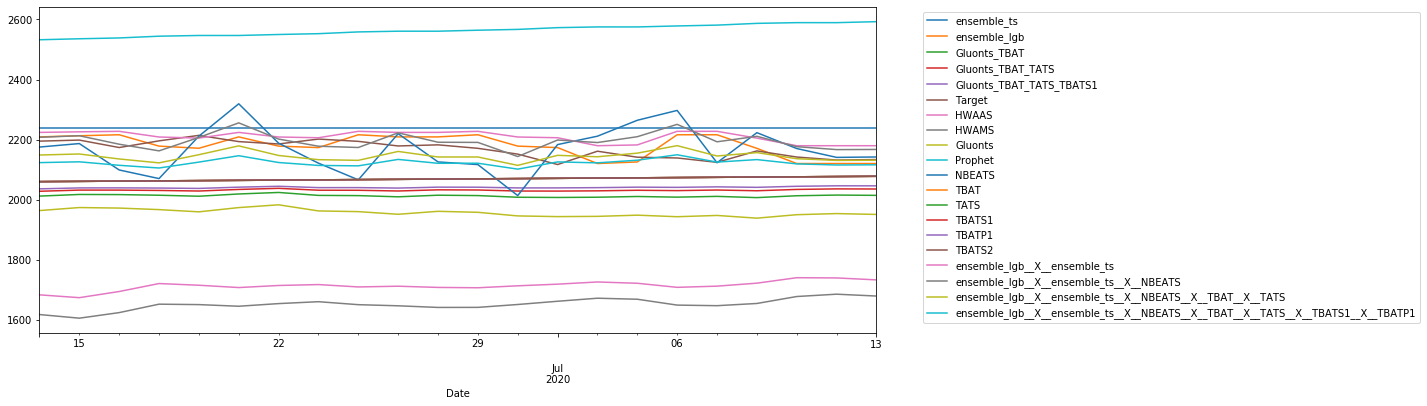

In [30]:
all_ensemble_in.plot(figsize=(15,6))
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper_right')
plt.show()

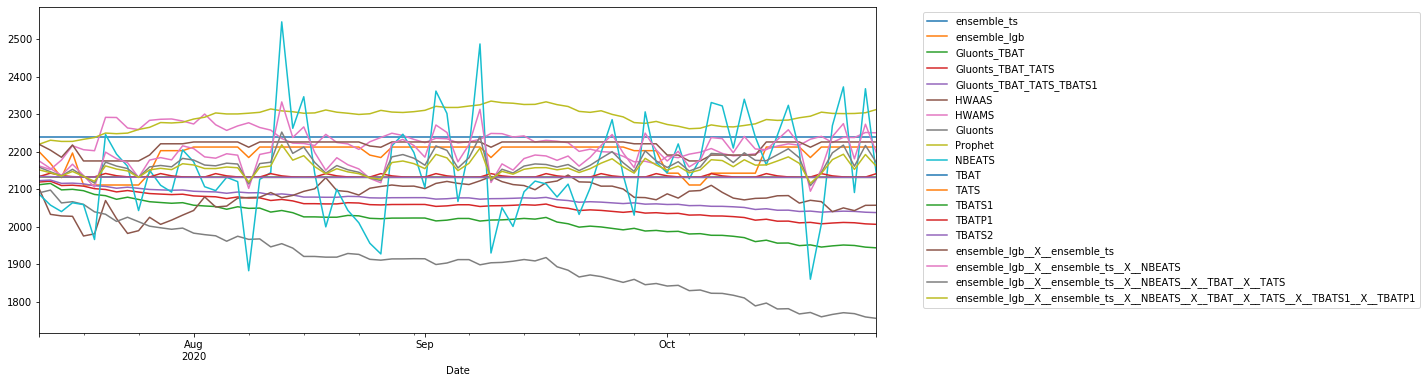

In [31]:
all_ensemble_out.plot(figsize=(15,6))
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper_right')
plt.show()

In [32]:
forecast_out.head(3)

,HWAAS,HWAMS,Gluonts,Prophet,NBEATS,TBAT,TATS,TBATS1,TBATP1,TBATS2
Date,,,,,,,,,,
2020-07-14,2099.384457,2161.467125,2090.270752,2219.925461,2085.545410,2133.407841,2133.407841,2133.407841,2133.744293,2133.407841
2020-07-15,2032.719433,2152.424767,2097.378174,2230.334485,2057.367920,2133.020983,2133.020983,2133.020983,2142.542139,2133.020983
2020-07-16,2028.547185,2177.504668,2063.196533,2227.122947,2040.095703,2132.711574,2132.711574,2132.711574,2136.299331,2132.711574


In [34]:
test_df.head(3)

,Close
2020-07-14,2159.250000
2020-07-15,2123.500000
2020-07-16,2124.449951


In [38]:
from sklearn.metrics import mean_squared_error

In [39]:
models = forecast_out.columns
rmse_models = {}
for i in models:
    rmse = np.sqrt(mean_squared_error(test_df['Close'].values, forecast_out[i].values))
    rmse_models[i] = rmse

In [40]:
rmse_models

{'Gluonts': 328.77889778677456,
 'HWAAS': 148.96175020654266,
 'HWAMS': 127.71809596819178,
 'NBEATS': 153.82022899678995,
 'Prophet': 154.60588122386892,
 'TATS': 114.85527710544068,
 'TBAT': 114.85527710544068,
 'TBATP1': 113.65421564592144,
 'TBATS1': 114.85527710544068,
 'TBATS2': 114.85527710544068}

In [43]:
ensemble_models = all_ensemble_out.columns
ensemble_rmse_models = {}
for i in ensemble_models:
    rmse = np.sqrt(mean_squared_error(test_df['Close'].values, all_ensemble_out[i].values))
    ensemble_rmse_models[i] = rmse

In [44]:
ensemble_rmse_models

{'Gluonts': 328.77889778677456,
 'Gluonts_TBAT': 214.26358121205575,
 'Gluonts_TBAT_TATS': 178.1257245127006,
 'Gluonts_TBAT_TATS_TBATS1': 160.8310191668213,
 'HWAAS': 148.96175020654266,
 'HWAMS': 127.71809596819178,
 'NBEATS': 153.82022899678995,
 'Prophet': 154.60588122386892,
 'TATS': 114.85527710544068,
 'TBAT': 114.85527710544068,
 'TBATP1': 113.65421564592144,
 'TBATS1': 114.85527710544068,
 'TBATS2': 114.85527710544068,
 'ensemble_lgb': 110.56600363691437,
 'ensemble_lgb__X__ensemble_ts': 111.3807134245409,
 'ensemble_lgb__X__ensemble_ts__X__NBEATS': 107.46398836271341,
 'ensemble_lgb__X__ensemble_ts__X__NBEATS__X__TBAT__X__TATS': 103.86111276830958,
 'ensemble_lgb__X__ensemble_ts__X__NBEATS__X__TBAT__X__TATS__X__TBATS1__X__TBATP1': 104.98379980331805,
 'ensemble_ts': 120.08778234312624}

## **Try: Handling Errors**

In [ ]:
# ValueError: Inferred frequency None from passed values does not conform to passed frequency C
def _validate_frequency(cls, index, freq, **kwargs):
    return None

pd.core.arrays.datetimelike.DatetimeLikeArrayMixin._validate_frequency = _validate_frequency

In [ ]:
df.index.freq='D'

In [ ]:
#UnboundLocalError: local variable 'periodocity' referenced before assignment 
def infer_periodocity(train):
#Prev:  perd = pd.infer_freq(train.index)
    perd = "D" # Updated here
    if perd in ["MS","M","BM","BMS"]:
    periodocity = 12
    elif perd in ["BH","H"]:
    periodocity = 24
    elif perd=="B":
    periodocity = 5
    elif perd=="D":
    periodocity = 7
    elif perd=="W":
    periodocity = 52
    elif perd in ["Q","QS","BQ","BQS"]:
    periodocity = 4
    elif perd in ["A","BA","AS","BAS"]:
    periodocity = 10
    elif perd in ["T","min"]:
    periodocity = 60
    elif perd=="S":
    periodocity = 60
    elif perd in ["L","ms"]:
    periodocity = 1000
    elif perd in ["U","us"]:
    periodocity = 1000
    elif perd=="N":
    periodocity = 1000

    return periodocity 

In [ ]:
# Back to normal
def parse_data(df):
  if type(df) ==pd.DataFrame:
    if df.shape[1]>1:
      raise ValueError("The dataframe should only contain one target column")
  elif type(df) == pd.Series:
    df = df.to_frame()
  else:
    raise TypeError("Please supply a pandas dataframe with one column or a pandas series")
  try:
    df.index.date
  except AttributeError: 
    raise TypeError("The index should be a datetype")
  print(type(df))
  if df.isnull().any().values[0]:
    raise ValueError("The dataframe cannot have any null values, please interpolate")
  try:
    df.columns = ["Target"]
  except:
    raise ValueError("There should only be one column")

  df.index = df.index.rename("Date")
  df.index = add_freq(df.index)

  print("The data has been successfully parsed by infering a frequency, and establishing a 'Date' index and 'Target' column.")

  return df, df.index.freq # Updated here
# Prev: return df, pd.infer_freq(df.index)

<Day>

## **3. Atspy Models for %Change Values**

In [6]:
df = hul_df.copy()
df = df[['%Change']] 
df.shape

(768, 1)

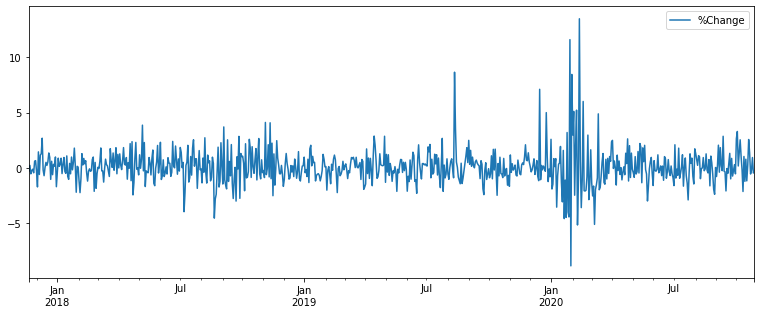

In [11]:
df.plot(figsize=(13,5))

In [7]:
# Creating date indexes to work Atspy models (to avoid validation errors)
dates = pd.date_range(start=df.index[0].date(), freq="B", periods=len(df))
dates

DatetimeIndex(['2017-11-20', '2017-11-21', '2017-11-22', '2017-11-23',
               '2017-11-24', '2017-11-27', '2017-11-28', '2017-11-29',
               '2017-11-30', '2017-12-01',
               ...
               '2020-10-15', '2020-10-16', '2020-10-19', '2020-10-20',
               '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-26',
               '2020-10-27', '2020-10-28'],
              dtype='datetime64[ns]', length=768, freq='B')

In [12]:
df.index = dates
train_df = df.iloc[0:int(0.90*len(df))]
test_df = df.iloc[int(0.90*len(df)):]

In [13]:
print("No. of samples in train data: {}".format(train_df.shape))
print("No. of samples in test data: {}".format(test_df.shape))

No. of samples in train data: (691, 1)
No. of samples in test data: (77, 1)


In [14]:
print(train_df.index.freq)

<BusinessDay>


In [15]:
model_list=["HWAAS","HWAMS","Gluonts","Prophet","NBEATS", "TBAT", "TATS", "TBATS1", "TBATP1", "TBATS2"]

am = AutomatedModel(df=train_df, model_list=model_list, 
                    season="infer_from_data", forecast_len=77)
forecast_in, performance = am.forecast_insample()
forecast_out = am.forecast_outsample()

<class 'pandas.core.frame.DataFrame'>
The data has been successfully parsed by infering a frequency, and establishing a 'Date' index and 'Target' column.
518
An insample split of training size 518 and testing size 173 has been constructed
Model HWAAS is being trained for in sample prediction


INFO:root:Start model training


Model HWAMS is being trained for in sample prediction
Model Gluonts is being trained for in sample prediction


INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:18<00:00,  2.69it/s, avg_epoch_loss=1.65]
INFO:root:Epoch[0] Elapsed time 18.582 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.651968
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:16<00:00,  3.12it/s, avg_epoch_loss=1.55]
INFO:root:Epoch[1] Elapsed time 16.023 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.552622
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:16<00:00,  3.11it/s, avg_epoch_loss=1.36]
INFO:root:Epoch[2] Elapsed time 16.083 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=1.359010
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:16<00:00,  3.12it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[3] Elapsed time 16.035 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=1.088314
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:16<00:00,  3.11it/s, avg_epoch_loss=0.88] 
INFO:root:Epoch[4] E

Model Prophet is being trained for in sample prediction
Model NBEATS is being trained for in sample prediction
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=173, forecast_length=173, share_thetas=False) at @139634941138592
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=173, forecast_length=173, share_thetas=False) at @139634941113344
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=173, forecast_length=173, share_thetas=False) at @139634941114072
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=173, forecast_length=173, share_thetas=False) at @139634941114800
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=173, forecast_length=173, share_thetas=False) at @139634941114744
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=173, forecast_length=173, share_thetas=False) at @139

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

Model HWAMS is being trained for out of sample prediction
Model Gluonts is being trained for out of sample prediction


INFO:root:Number of parameters in DeepARTrainingNetwork: 22204
100%|██████████| 50/50 [00:08<00:00,  5.94it/s, avg_epoch_loss=1.75]
INFO:root:Epoch[0] Elapsed time 8.419 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.747180
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:08<00:00,  6.22it/s, avg_epoch_loss=1.64]
INFO:root:Epoch[1] Elapsed time 8.046 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.642270
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:07<00:00,  6.44it/s, avg_epoch_loss=1.55]
INFO:root:Epoch[2] Elapsed time 7.772 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=1.551256
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:07<00:00,  6.43it/s, avg_epoch_loss=1.43]
INFO:root:Epoch[3] Elapsed time 7.777 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=1.427289
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:07<00:00,  6.51it/s, avg_epoch_loss=1.31]
INFO

Model Prophet is being trained for out of sample prediction
Model NBEATS is being trained for out of sample prediction
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=77, forecast_length=77, share_thetas=False) at @139634940406528
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=77, forecast_length=77, share_thetas=False) at @139634939915960
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=77, forecast_length=77, share_thetas=False) at @139634939913944
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=77, forecast_length=77, share_thetas=False) at @139634939953560
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=77, forecast_length=77, share_thetas=False) at @139634939955296
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=77, forecast_length=77, share_thetas=False) at @1396349

In [16]:
forecast_in.head()

,Target,HWAAS,HWAMS,Gluonts,Prophet,NBEATS,TBAT,TATS,TBATS1,TBATP1,TBATS2
Date,,,,,,,,,,,
2019-11-14,0.077,NaN,0.140501,1.297437,-0.049153,0.241395,0.050897,0.050897,0.050897,0.050897,0.050897
2019-11-15,-0.547,NaN,0.047829,0.049877,-0.099380,-0.147799,0.048883,0.048883,0.048883,0.048883,0.048883
2019-11-18,-0.623,NaN,0.157708,-0.188204,0.013601,0.228027,0.047214,0.047214,0.047214,0.047214,0.047214
2019-11-19,0.274,NaN,0.223984,-0.004021,0.074926,-0.364958,0.045832,0.045832,0.045832,0.045832,0.045832
2019-11-20,0.450,NaN,-0.147701,0.492224,0.256413,-0.089536,0.044688,0.044688,0.044688,0.044688,0.044688


In [17]:
forecast_in.to_pickle('/content/drive/MyDrive/INeuron-StockPredict/hul_per_change_files/hul_train.pkl')

In [18]:
forecast_out.to_pickle('/content/drive/MyDrive/INeuron-StockPredict/hul_per_change_files/hul_test.pkl')

In [19]:
forecast_out.head(3)

,HWAAS,HWAMS,Gluonts,Prophet,NBEATS,TBAT,TATS,TBATS1,TBATP1,TBATS2
2020-07-14,NaN,0.083789,0.590510,0.047553,0.558215,-0.117709,0.072450,0.139245,0.104423,0.092653
2020-07-15,NaN,0.030092,0.017707,0.456780,0.069034,-0.118166,0.083962,-0.040420,0.501912,0.093020
2020-07-16,NaN,-0.028155,-0.635106,-0.247674,0.500869,-0.118531,0.058142,0.014910,-0.216893,0.027966


In [20]:
forecast_in.shape

(173, 11)

In [21]:
forecast_out.shape

(77, 10)

In [22]:
performance.to_pickle('/content/drive/MyDrive/INeuron-StockPredict/hul_per_change_files/performance.pkl')

In [23]:
performance

,Target,HWAAS,HWAMS,Gluonts,Prophet,NBEATS,TBAT,TATS,TBATS1,TBATP1,TBATS2
rmse,0.000000,NaN,2.458549,2.512479,2.452972,2.463216,2.476745,2.476745,2.476745,2.476745,2.476745
mse,0.000000,NaN,6.044463,6.312550,6.017074,6.067431,6.134265,6.134265,6.134265,6.134265,6.134265
mean,0.086046,NaN,0.087883,-0.014937,0.021334,0.085904,0.039562,0.039562,0.039562,0.039562,0.039562


In [34]:
models = forecast_out.columns.drop('HWAAS') 
rmse_models = {}
for i in models:
    rmse = np.sqrt(mean_squared_error(test_df['%Change'].values, forecast_out[i].values))
    rmse_models[i] = rmse

In [35]:
rmse_models

{'Gluonts': 1.278859246868861,
 'HWAMS': 1.2507629418885,
 'NBEATS': 1.2713105119287404,
 'Prophet': 1.3238483313793388,
 'TATS': 1.2445307181917955,
 'TBAT': 1.267992890453894,
 'TBATP1': 1.3126126701762548,
 'TBATS1': 1.254244445931281,
 'TBATS2': 1.2456280564123916}

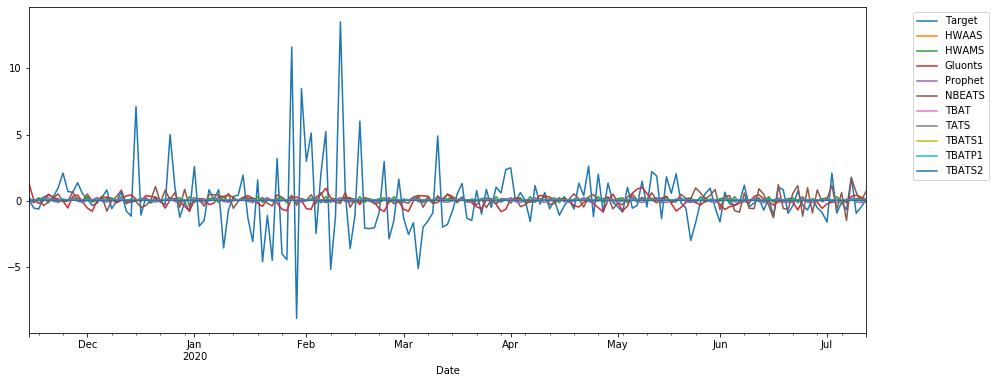

In [26]:
forecast_in.plot(figsize=(15,6))
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper_right')
plt.show()

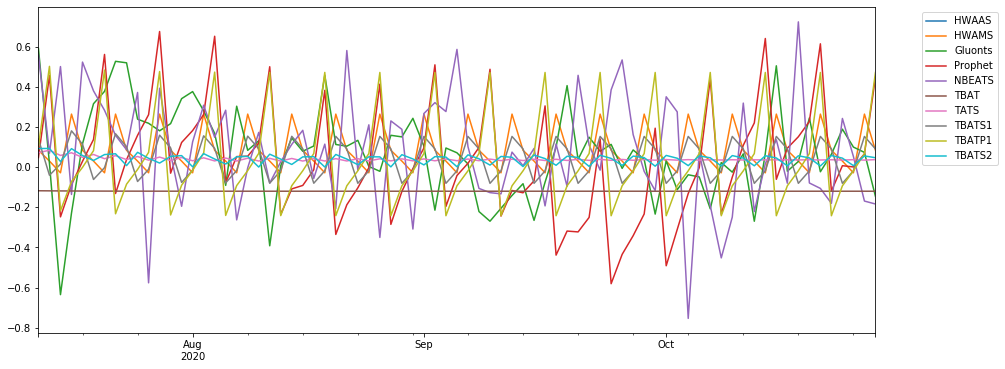

In [27]:
forecast_out.plot(figsize=(15,6))
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper_right')
plt.show()

In [25]:
all_ensemble_in, all_ensemble_out, all_performance = am.ensemble(forecast_in.drop('HWAAS', axis=1), forecast_out)

Building LightGBM Ensemble from TS data (ensemble_lgb)
Building LightGBM Ensemble from PCA reduced TSFresh Features (ensemble_ts). This can take a long time.
LightGBM ensemble have been successfully built
1046  variables are found to be almost constant


ZeroDivisionError: ignored

In [ ]:
all_performance

,rmse,mse,mean
ensemble_lgb,37.289814,1390.530249,2180.264883
ensemble_lgb__X__ensemble_ts__X__NBEATS__X__TBAT__X__TATS,38.961411,1517.991546,2145.030686
ensemble_lgb__X__ensemble_ts__X__NBEATS,44.913474,2017.220134,2195.491145
ensemble_lgb__X__ensemble_ts,49.345067,2434.935596,2209.717674
ensemble_lgb__X__ensemble_ts__X__NBEATS__X__TBAT__X__TATS__X__TBATS1__X__TBATP1,54.207932,2938.499913,2123.404775
ensemble_ts,76.542915,5858.817846,2239.170466
NBEATS,79.464938,6314.676424,2167.038330
TBAT,103.827922,10780.237453,2069.339997
TATS,103.827922,10780.237453,2069.339997
TBATS1,103.827922,10780.237453,2069.339997


In [ ]:
all_ensemble_in.to_pickle('/content/drive/MyDrive/INeuron-StockPredict/nifty_top5_data/hul_ensemble_in.pkl')

In [ ]:
all_ensemble_out.to_pickle('/content/drive/MyDrive/INeuron-StockPredict/nifty_top5_data/hul_ensemble_out.pkl')

In [ ]:
all_performance.to_pickle('/content/drive/MyDrive/INeuron-StockPredict/nifty_top5_data/all_performance.pkl')

In [ ]:
all_ensemble_in.head(3)

,ensemble_ts,ensemble_lgb,Gluonts_TBAT,Gluonts_TBAT_TATS,Gluonts_TBAT_TATS_TBATS1,Target,HWAAS,HWAMS,Gluonts,Prophet,NBEATS,TBAT,TATS,TBATS1,TBATP1,TBATS2,ensemble_lgb__X__ensemble_ts,ensemble_lgb__X__ensemble_ts__X__NBEATS,ensemble_lgb__X__ensemble_ts__X__NBEATS__X__TBAT__X__TATS,ensemble_lgb__X__ensemble_ts__X__NBEATS__X__TBAT__X__TATS__X__TBATS1__X__TBATP1
Date,,,,,,,,,,,,,,,,,,,,
2020-06-12,2239.170466,2209.214998,2012.354379,2028.400280,2036.423231,2195.100098,1683.965274,1618.455677,1964.216675,2532.270123,2175.444092,2060.492083,2060.492083,2060.492083,2060.492083,2060.492083,2224.192732,2207.943185,2148.962744,2123.685412
2020-06-15,2239.170466,2213.088756,2017.805142,2032.314245,2039.568797,2198.649902,1674.579038,1606.380172,1974.277832,2535.570263,2187.046387,2061.332452,2061.332452,2061.332452,2061.332452,2061.332452,2226.129611,2213.101869,2152.394102,2126.376488
2020-06-16,2239.170466,2216.331473,2017.344700,2032.287521,2039.758932,2173.899902,1695.019399,1624.873985,1972.516235,2538.295023,2099.270752,2062.173164,2062.173164,2062.173164,2062.173164,2062.173164,2227.750969,2184.924230,2135.823804,2114.780764


In [ ]:
forecast_out.head(3)

,HWAAS,HWAMS,Gluonts,Prophet,NBEATS,TBAT,TATS,TBATS1,TBATP1,TBATS2
Date,,,,,,,,,,
2020-07-14,2099.384457,2161.467125,2090.270752,2219.925461,2085.545410,2133.407841,2133.407841,2133.407841,2133.744293,2133.407841
2020-07-15,2032.719433,2152.424767,2097.378174,2230.334485,2057.367920,2133.020983,2133.020983,2133.020983,2142.542139,2133.020983
2020-07-16,2028.547185,2177.504668,2063.196533,2227.122947,2040.095703,2132.711574,2132.711574,2132.711574,2136.299331,2132.711574


In [ ]:
test_df.head(3)

,Close
2020-07-14,2159.250000
2020-07-15,2123.500000
2020-07-16,2124.449951


In [ ]:
rmse_models

{'Gluonts': 328.77889778677456,
 'HWAAS': 148.96175020654266,
 'HWAMS': 127.71809596819178,
 'NBEATS': 153.82022899678995,
 'Prophet': 154.60588122386892,
 'TATS': 114.85527710544068,
 'TBAT': 114.85527710544068,
 'TBATP1': 113.65421564592144,
 'TBATS1': 114.85527710544068,
 'TBATS2': 114.85527710544068}

In [ ]:
ensemble_models = all_ensemble_out.columns
ensemble_rmse_models = {}
for i in ensemble_models:
    rmse = np.sqrt(mean_squared_error(test_df['Close'].values, all_ensemble_out[i].values))
    ensemble_rmse_models[i] = rmse

In [ ]:
ensemble_rmse_models

{'Gluonts': 328.77889778677456,
 'Gluonts_TBAT': 214.26358121205575,
 'Gluonts_TBAT_TATS': 178.1257245127006,
 'Gluonts_TBAT_TATS_TBATS1': 160.8310191668213,
 'HWAAS': 148.96175020654266,
 'HWAMS': 127.71809596819178,
 'NBEATS': 153.82022899678995,
 'Prophet': 154.60588122386892,
 'TATS': 114.85527710544068,
 'TBAT': 114.85527710544068,
 'TBATP1': 113.65421564592144,
 'TBATS1': 114.85527710544068,
 'TBATS2': 114.85527710544068,
 'ensemble_lgb': 110.56600363691437,
 'ensemble_lgb__X__ensemble_ts': 111.3807134245409,
 'ensemble_lgb__X__ensemble_ts__X__NBEATS': 107.46398836271341,
 'ensemble_lgb__X__ensemble_ts__X__NBEATS__X__TBAT__X__TATS': 103.86111276830958,
 'ensemble_lgb__X__ensemble_ts__X__NBEATS__X__TBAT__X__TATS__X__TBATS1__X__TBATP1': 104.98379980331805,
 'ensemble_ts': 120.08778234312624}

## **4. Results**

### **4.1 Atspy - HUL Close Prices**

In [67]:
df = hul_df.copy()
df = df[['Close']] 
df.shape

(768, 1)

In [68]:
train_df = df.iloc[0:int(0.90*len(df))]
test_df = df.iloc[int(0.90*len(df)):]
print("No of samples in train data: {}".format(train_df.shape))
print("No of samples in test data: {}".format(test_df.shape))

No of samples in train data: (691, 1)
No of samples in test data: (77, 1)


In [92]:
models_forecast = pd.read_pickle('/content/drive/MyDrive/INeuron-StockPredict/nifty_top5_data/hul_ensemble_out.pkl')
ensemble_models = models_forecast.columns
ensemble_rmse_models = {}
for i in ensemble_models:
    rmse = np.sqrt(mean_squared_error(test_df['Close'].values, models_forecast[i].values))
    ensemble_rmse_models[i] = rmse
    
df_rmse = pd.DataFrame.from_dict(ensemble_rmse_models, orient='index')
df_rmse.sort_values(by=0, inplace=True)
df_rmse.head(5)

,0
ensemble_lgb__X__ensemble_ts__X__NBEATS__X__TBAT__X__TATS,103.861113
ensemble_lgb__X__ensemble_ts__X__NBEATS__X__TBAT__X__TATS__X__TBATS1__X__TBATP1,104.983800
ensemble_lgb__X__ensemble_ts__X__NBEATS,107.463988
ensemble_lgb,110.566004
ensemble_lgb__X__ensemble_ts,111.380713


In [75]:
models_forecast['Actual Test'] = test_df.values
models_forecast.index = test_df.index
models_forecast.head(3)

,ensemble_ts,ensemble_lgb,Gluonts_TBAT,Gluonts_TBAT_TATS,Gluonts_TBAT_TATS_TBATS1,HWAAS,HWAMS,Gluonts,Prophet,NBEATS,TBAT,TATS,TBATS1,TBATP1,TBATS2,ensemble_lgb__X__ensemble_ts,ensemble_lgb__X__ensemble_ts__X__NBEATS,ensemble_lgb__X__ensemble_ts__X__NBEATS__X__TBAT__X__TATS,ensemble_lgb__X__ensemble_ts__X__NBEATS__X__TBAT__X__TATS__X__TBATS1__X__TBATP1,Actual Test
Date,,,,,,,,,,,,,,,,,,,,
2020-09-11,2239.170466,2198.798380,2111.839296,2119.028811,2122.623568,2099.384457,2161.467125,2090.270752,2219.925461,2085.545410,2133.407841,2133.407841,2133.407841,2133.744293,2133.407841,2218.984423,2174.504752,2158.065987,2151.068867,2159.250000
2020-09-14,2239.170466,2168.477403,2115.199579,2121.140047,2124.110281,2032.719433,2152.424767,2097.378174,2230.334485,2057.367920,2133.020983,2133.020983,2133.020983,2142.542139,2133.020983,2203.823934,2155.005263,2146.211551,2143.802983,2123.500000
2020-09-15,2239.170466,2130.674479,2097.954053,2109.539894,2115.332814,2028.547185,2177.504668,2063.196533,2227.122947,2040.095703,2132.711574,2132.711574,2132.711574,2136.299331,2132.711574,2184.922472,2136.646883,2135.072759,2134.910671,2124.449951


In [90]:
models_forecast.drop(['TBATS2', 'TBATS1', 'TBAT'],axis=1, inplace=True)
model_names = models_forecast.columns.tolist()
for model in model_names:
    if model != 'Actual Test':
        fig = go.Figure()
        date = models_forecast.index.tolist()
        y_true = models_forecast['Actual Test'].values.tolist()
        y_pred = models_forecast[model].values.tolist()

        fig.add_trace(go.Scatter(
            x=date,
            y=y_true,
            name="Actual Test"       # this sets its legend entry
        ))

        fig.add_trace(go.Scatter(
            x=date,
            y=y_pred,
            name=model,
        ))

        fig.update_layout(   
            width=1100, 
            height=300,    
            xaxis_title="Date",
            yaxis_title="Close Prices",
            legend_title="Legend",
            font=dict(
                family="Courier New, monospace",
                size=12,
                color="RebeccaPurple"
            ))
        fig.show()

### **4.2 Atspy - HUL %Change Prices**

In [93]:
df = hul_df.copy()
df = df[['%Change']] 
df.shape

(768, 1)

In [94]:
train_df = df.iloc[0:int(0.90*len(df))]
test_df = df.iloc[int(0.90*len(df)):]
print("No of samples in train data: {}".format(train_df.shape))
print("No of samples in test data: {}".format(test_df.shape))

No of samples in train data: (691, 1)
No of samples in test data: (77, 1)


In [97]:
models_forecast = pd.read_pickle('/content/drive/MyDrive/INeuron-StockPredict/hul_per_change_files/hul_test.pkl')
models_forecast.head()

,HWAAS,HWAMS,Gluonts,Prophet,NBEATS,TBAT,TATS,TBATS1,TBATP1,TBATS2
2020-07-14,NaN,0.083789,0.590510,0.047553,0.558215,-0.117709,0.072450,0.139245,0.104423,0.092653
2020-07-15,NaN,0.030092,0.017707,0.456780,0.069034,-0.118166,0.083962,-0.040420,0.501912,0.093020
2020-07-16,NaN,-0.028155,-0.635106,-0.247674,0.500869,-0.118531,0.058142,0.014910,-0.216893,0.027966
2020-07-17,NaN,0.264110,-0.228874,-0.087520,-0.136165,-0.118824,0.071596,0.180730,-0.072181,0.092105
2020-07-20,NaN,0.083789,0.116046,0.029001,0.523152,-0.119058,0.048452,0.113892,-0.001228,0.057711


In [98]:
models_forecast.drop('HWAAS', axis=1, inplace=True)
ensemble_models = models_forecast.columns
ensemble_rmse_models = {}
for i in ensemble_models:
    rmse = np.sqrt(mean_squared_error(test_df['%Change'].values, models_forecast[i].values))
    ensemble_rmse_models[i] = rmse
    
df_rmse = pd.DataFrame.from_dict(ensemble_rmse_models, orient='index')
df_rmse.sort_values(by=0, inplace=True)
df_rmse.head(5)

,0
TATS,1.244531
TBATS2,1.245628
HWAMS,1.250763
TBATS1,1.254244
TBAT,1.267993


In [99]:
models_forecast['Actual Test'] = test_df.values
models_forecast.index = test_df.index
models_forecast.head(3)

,HWAMS,Gluonts,Prophet,NBEATS,TBAT,TATS,TBATS1,TBATP1,TBATS2,Actual Test
Date,,,,,,,,,,
2020-09-11,0.083789,0.590510,0.047553,0.558215,-0.117709,0.072450,0.139245,0.104423,0.092653,1.188
2020-09-14,0.030092,0.017707,0.456780,0.069034,-0.118166,0.083962,-0.040420,0.501912,0.093020,-1.656
2020-09-15,-0.028155,-0.635106,-0.247674,0.500869,-0.118531,0.058142,0.014910,-0.216893,0.027966,0.045


In [100]:
model_names = models_forecast.columns.tolist()
for model in model_names:
    if model != 'Actual Test':
        fig = go.Figure()
        date = models_forecast.index.tolist()
        y_true = models_forecast['Actual Test'].values.tolist()
        y_pred = models_forecast[model].values.tolist()

        fig.add_trace(go.Scatter(
            x=date,
            y=y_true,
            name="Actual Test"       # this sets its legend entry
        ))

        fig.add_trace(go.Scatter(
            x=date,
            y=y_pred,
            name=model,
        ))

        fig.update_layout(   
            width=1100, 
            height=300,    
            xaxis_title="Date",
            yaxis_title="%Change in Close Prices",
            legend_title="Legend",
            font=dict(
                family="Courier New, monospace",
                size=12,
                color="RebeccaPurple"
            ))
        fig.show()